## Prediction Model to Detect Replay Attacks

The dataset combines replay attack PCAPs from SCAS and a clean data PCAP from the Loadcore.


Different test cases from the SCAS will be consider.
At the end a class will be created to manage prediction models for different test cases. This class will serve as a single prediction framework for different scenarios.

In [ ]:
#Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

In [16]:
#  pandas reads (pd.read_csv) the dataset into a DataFrame with all values as strings which expects semicolon-separated values.

df = pd.read_csv('data.csv', dtype=str, sep=";")


# This (df.shape) gives the total number of rows and columns in the DataFrame as a tuple (rows, columns)

df.shape

(910, 25)

In [17]:
# reading the first 20 rows in the dataframe

df.loc[0:20]

,Time,AMF_UE_NGAP_ID,ip_source,procedureCode,EPD,spare,SecHdr,Type,5GSID,UESecCap,...,Seqn,EPD_2,spare_2,SecHdr_2,NASSecAlgo,EPD_3,spare_3,SecHdr_3,Type_2,DeregistrationType
0,1.789354,-1,20.0.2.10,15,126,0,0,65,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.799491,0,20.0.20.10,4,126,0,0,86,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.799763,0,20.0.2.10,46,126,0,0,87,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.802804,0,20.0.20.10,4,126,0,3,93,NaN,2,...,0,126,0,0,0,NaN,NaN,NaN,NaN,NaN
4,1.803024,0,20.0.2.10,46,126,0,4,94,13,2,...,0,126,0,0,NaN,126,0,0,65,NaN
5,1.852927,0,20.0.20.10,14,126,0,2,66,NaN,NaN,...,1,126,0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,1.853258,0,20.0.2.10,46,126,0,2,67,NaN,NaN,...,1,126,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7,1.853461,0,20.0.2.10,46,126,0,2,103,NaN,NaN,...,2,126,0,0,NaN,46,NaN,NaN,NaN,NaN
8,1.910148,0,20.0.20.10,29,126,0,2,103,NaN,NaN,...,2,126,0,0,NaN,46,NaN,NaN,NaN,NaN
9,1.968751,-1,20.0.2.10,15,126,0,0,65,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
"""
All NaN values is filled with unique placeholder ''999999999'  (NAN  stands for not a number (empty values). 
0 is not use as a value for the placeholder because 0 is a valid value in the dataset

"""


df.fillna(999999999, inplace=True)

# All occurrences of -1 and NAN is replaced with the unique placeholders before feeding it into the model
df.replace('-1', '999999999', inplace=True) 


In [19]:
# Convert values to appropriate types where possible
def convert_float_int_or_numeric_placeholder(val):
    try:
        # convert to float first, then check if it's an integer
        f_val = float(val)
        if f_val.is_integer():
            return int(f_val)
        return f_val
    except ValueError:
        if str(val) == '999999999': # Explicitly handle our placeholder string
             return float(val) # Convert it to a numeric float
        return str(val) 

df = df.applymap(convert_float_int_or_numeric_placeholder) # Use applymap for element-wise operation

# reading the first 20 rows in the dataframe

df.loc[0:20]


C:\Users\ovuoruke\AppData\Local\Temp\ipykernel_16520\753532457.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(convert_float_int_or_numeric_placeholder) # Use applymap for element-wise operation


,Time,AMF_UE_NGAP_ID,ip_source,procedureCode,EPD,spare,SecHdr,Type,5GSID,UESecCap,...,Seqn,EPD_2,spare_2,SecHdr_2,NASSecAlgo,EPD_3,spare_3,SecHdr_3,Type_2,DeregistrationType
0,1.789354,999999999,20.0.2.10,15,126,0,0,65,13,2,...,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999
1,1.799491,0,20.0.20.10,4,126,0,0,86,999999999,999999999,...,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999
2,1.799763,0,20.0.2.10,46,126,0,0,87,999999999,999999999,...,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999
3,1.802804,0,20.0.20.10,4,126,0,3,93,999999999,2,...,0,126,0,0,0,999999999,999999999,999999999,999999999,999999999
4,1.803024,0,20.0.2.10,46,126,0,4,94,13,2,...,0,126,0,0,999999999,126,0,0,65,999999999
5,1.852927,0,20.0.20.10,14,126,0,2,66,999999999,999999999,...,1,126,0,0,999999999,999999999,999999999,999999999,999999999,999999999
6,1.853258,0,20.0.2.10,46,126,0,2,67,999999999,999999999,...,1,126,0,0,999999999,999999999,999999999,999999999,999999999,999999999
7,1.853461,0,20.0.2.10,46,126,0,2,103,999999999,999999999,...,2,126,0,0,999999999,46,999999999,999999999,999999999,999999999
8,1.910148,0,20.0.20.10,29,126,0,2,103,999999999,999999999,...,2,126,0,0,999999999,46,999999999,999999999,999999999,999999999
9,1.968751,999999999,20.0.2.10,15,126,0,0,65,13,2,...,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999,999999999


In [20]:

"""
The list of contamination values tells the Isolation Forest model what is the expected proportion of anomalies (outliers) in the dataset. 
Each value in the list represents a different assumption about how much of the data is abnormal. For instances, 0.01 assumes 1% 
of the data is anomalous, while 0.25 assumes 25%. By testing multiple contamination levels, the model can compare how many 
anomalies are detected and how strongly anomalous they are (based on their anomaly scores).

In other words, contamination helps the model decide what to flag as normal and what to flag as abnormal (anomaly). 
"""

contamination_values = [0.01, 0.02, 0.05, 0.10, 0.15, 0.25, 0.35]  

#### Tests and selects the best contamination value by comparing results from multiple models 

In [24]:

results = {}

# Drop non-useful columns
df_clean = df.drop(columns=['Time', 'ip_source', 'AMF_UE_NGAP_ID'], errors='ignore')

# Identify numerical and categorical columns after initial transformations
numerical_cols = df_clean.select_dtypes(include=np.number).columns
categorical_cols = df_clean.select_dtypes(include='object').columns


"""
This loops through each column that are catogorical. 
For each of the column, it changes those strings into numbers using fit_transform() then Encode non-numeric features

"""
for col in categorical_cols:
    df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))


# The StandardScaler normalizes the data, making sure all features are on the same scale.  
scaler = StandardScaler()


df_scaled = scaler.fit_transform(df_clean)

# Convert the scaled array back to a DataFrame, preserving column names
df_scaled = pd.DataFrame(df_scaled, columns=df_clean.columns, index=df_clean.index)


# tests and selects the best contamination value by comparing results from multiple models 
for c in contamination_values:
    model = IsolationForest(n_estimators=100, contamination=c, random_state=42)
    # Fit the model on the SCALED DataFrame
    model.fit(df_scaled)
    
    preds = model.predict(df_scaled)
    scores = model.decision_function(df_scaled)
    
    # Filter anomaly scores for detected anomalies only
    anomaly_scores = scores[preds == -1]
    
    # Calculate mean anomaly score (lower = more anomalous)
    mean_score = np.mean(anomaly_scores) if len(anomaly_scores) > 0 else np.inf
    
    results[c] = {
        'num_anomalies': (preds == -1).sum(),
        'mean_anomaly_score': mean_score
    }
    
    print(f"Contamination: {c} — Anomalies: {results[c]['num_anomalies']} — Mean anomaly score: {mean_score:.4f}")

# Select contamination with lowest mean anomaly score (strongest anomalies)
best_c = min(results, key=lambda x: results[x]['mean_anomaly_score'])
print(f"\nSelected best contamination: {best_c} with mean anomaly score {results[best_c]['mean_anomaly_score']:.4f}")

Contamination: 0.01 — Anomalies: 4 — Mean anomaly score: -0.0660
Contamination: 0.02 — Anomalies: 4 — Mean anomaly score: -0.0660
Contamination: 0.05 — Anomalies: 4 — Mean anomaly score: -0.0660
Contamination: 0.1 — Anomalies: 4 — Mean anomaly score: -0.0660
Contamination: 0.15 — Anomalies: 104 — Mean anomaly score: -0.0231
Contamination: 0.25 — Anomalies: 205 — Mean anomaly score: -0.0153
Contamination: 0.35 — Anomalies: 305 — Mean anomaly score: -0.0180

Selected best contamination: 0.01 with mean anomaly score -0.0660


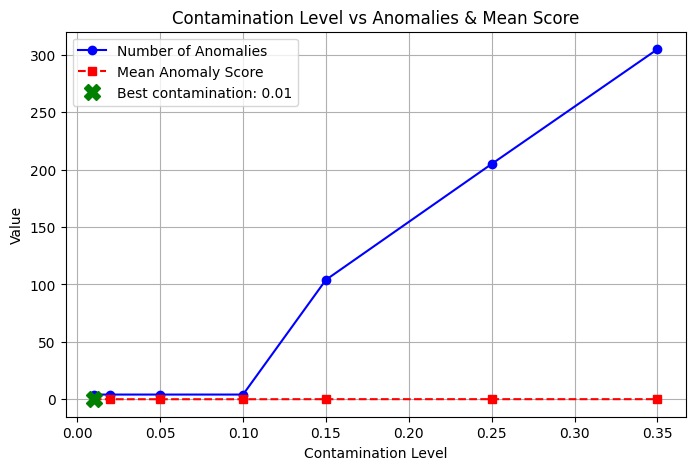

In [30]:
# Data
contamination_list = list(results.keys())
num_anomalies = [results[c]['num_anomalies'] for c in contamination_list]
mean_scores = [results[c]['mean_anomaly_score'] for c in contamination_list]

# Simple plot
plt.figure(figsize=(8, 5))

# Plot number of anomalies
plt.plot(contamination_list, num_anomalies, 'bo-', label='Number of Anomalies')

# Plot mean anomaly score
plt.plot(contamination_list, mean_scores, 'rs--', label='Mean Anomaly Score')

# Mark best contamination
best_idx = contamination_list.index(best_c)
plt.plot(best_c, mean_scores[best_idx], 'gX', markersize=12, label=f'Best contamination: {best_c}')

# Labels and title
plt.xlabel('Contamination Level')
plt.ylabel('Value')
plt.title('Contamination Level vs Anomalies & Mean Score')
plt.legend()
plt.grid(True)
plt.show()


#### Train model with best contamination using SCALED data

In [26]:

best_model = IsolationForest(n_estimators=100, contamination=best_c, random_state=42)
best_model.fit(df_scaled)

# Predict anomalies and scores on the SCALED data
df['anomaly'] = best_model.predict(df_scaled)
df['anomaly_score'] = best_model.decision_function(df_scaled)

#### print rows marked as anomalies

In [27]:

anomalies = df[df['anomaly'] == -1].copy()

# Define thresholds 
low_thresh = anomalies['anomaly_score'].quantile(0.66)
high_thresh = anomalies['anomaly_score'].quantile(0.33)

# Apply severity levels based on anomaly_score
def severity_label(score):
    if score <= high_thresh:
        return 'High'
    elif score <= low_thresh:
        return 'Medium'
    else:
        return 'Low'

anomalies['severity'] = anomalies['anomaly_score'].apply(severity_label)

# Print the selected columns including severity, Type, Time, anomaly_score
print(anomalies[['Time', 'Type', 'anomaly_score', 'severity']])


          Time  Type  anomaly_score severity
900   0.040010    65      -0.054991      Low
904   0.043320    94      -0.102106     High
905   0.043333    94      -0.102106     High
909  32.168309    69      -0.004603      Low


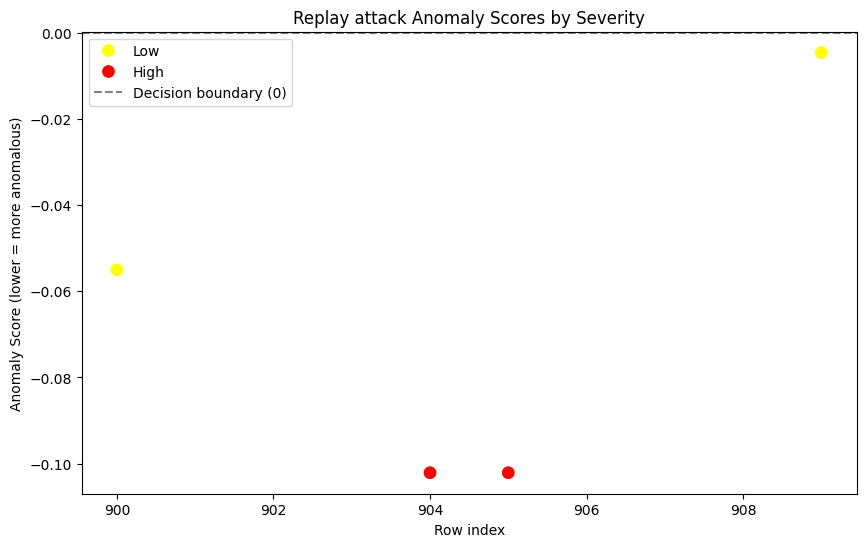

In [28]:

plt.figure(figsize=(10, 6))

# Scatter plot: index vs anomaly_score, colored by severity
sns.scatterplot(x=anomalies.index, y=anomalies['anomaly_score'], hue=anomalies['severity'],
                palette={'High':'red', 'Medium':'orange', 'Low':'yellow'}, s=100)

k = plt.axhline(y=0, color='gray', linestyle='--', label='Decision boundary (0)')
k = plt.title('Replay attack Anomaly Scores by Severity')
k = plt.xlabel('Row index')
k = plt.ylabel('Anomaly Score (lower = more anomalous)')
k = plt.legend()
k = plt.show()
k



In [29]:
# Filter high severity anomalies
high_sev_anomalies = anomalies[anomalies['severity'] == 'High']

print("\nHigh severity anomalies source")
print(high_sev_anomalies[['ip_source', 'AMF_UE_NGAP_ID', 'severity']])



High severity anomalies source
     ip_source  AMF_UE_NGAP_ID severity
904  20.0.2.10    549755813888     High
905  20.0.2.10    549755813888     High
